Cell1

In [2]:
import sys
import os

# Project root: one level up from notebooks/
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

# Canonical path to pricing.yaml
PRICING_PATH = os.path.join(repo_root, "data", "raw", "pricing.yaml")

print("Repo root:", repo_root)
print("Pricing path:", PRICING_PATH)


Repo root: /Users/bjh/Desktop/cell_OS
Pricing path: /Users/bjh/Desktop/cell_OS/data/raw/pricing.yaml


Cell2

In [3]:
import numpy as np
import pandas as pd

from src.world_init import build_default_world
from src.lab_world_model import LabWorldModel, Campaign
from src.posteriors import DoseResponsePosterior

# Build the lab world (cell lines, workflows, pricing, campaigns)
world = build_default_world(PRICING_PATH)

rng = np.random.default_rng(42)

cell_lines = ["HepG2", "U2OS"]
compounds = ["staurosporine", "tunicamycin", "H2O2"]

# Dose grids
doses_small = np.array([0, 0.001, 0.01, 0.1, 0.3, 1, 3, 10])  # µM
doses_H2O2  = np.array([0, 3, 10, 30, 100, 300, 1000, 3000])  # µM, pretend

# True IC50 values
true_ic50 = {
    ("HepG2", "staurosporine"): 0.05,
    ("U2OS",  "staurosporine"): 0.20,
    ("HepG2", "tunicamycin"):   0.80,
    ("U2OS",  "tunicamycin"):   0.30,
    ("HepG2", "H2O2"):          150.0,
    ("U2OS",  "H2O2"):          250.0,
}

hill = {
    "staurosporine": 1.2,
    "tunicamycin":   1.0,
    "H2O2":          1.5,
}

def logistic_viability(dose, ic50, h=1.0):
    # 1 at 0 dose, goes to 0 at high dose
    return 1.0 / (1.0 + (dose / ic50) ** h)

rows = []

n_plates_per_line = 3
replicates_per_dose = 3
assay_time_h = 24

for cell in cell_lines:
    for p in range(1, n_plates_per_line + 1):
        plate_id = f"{cell}_P{p}"
        plate_factor = rng.normal(loc=1.0, scale=0.05)
        date = f"2025-11-0{p}"  # fake dates

        # Controls
        control_signal_mean = 1.0 * plate_factor
        for row in ["A", "B", "C", "D"]:
            for col in range(9, 13):
                well_id = f"{row}{col:02d}"
                raw_viab = rng.normal(loc=control_signal_mean, scale=0.05)
                rows.append(dict(
                    plate_id=plate_id,
                    well_id=well_id,
                    cell_line=cell,
                    compound="DMSO",
                    dose_uM=0.0,
                    time_h=assay_time_h,
                    raw_signal=raw_viab * 10000,
                    is_control=1,
                    date=date,
                    incubator_id="inc1",
                    liquid_handler_id="manual"
                ))

        # Treated wells
        for compound in compounds:
            doses = doses_H2O2 if compound == "H2O2" else doses_small

            for dose in doses:
                for rep in range(replicates_per_dose):
                    base_row = {"staurosporine": "A", "tunicamycin": "D", "H2O2": "G"}[compound]
                    row = chr(ord(base_row) + rep)

                    col_index = np.where(doses == dose)[0][0] + 1
                    well_id = f"{row}{col_index:02d}"

                    ic50 = true_ic50[(cell, compound)]
                    h = hill[compound]

                    true_viab = logistic_viability(dose, ic50, h) * plate_factor
                    raw_viab = rng.normal(loc=true_viab, scale=0.05)

                    rows.append(dict(
                        plate_id=plate_id,
                        well_id=well_id,
                        cell_line=cell,
                        compound=compound,
                        dose_uM=float(dose),
                        time_h=assay_time_h,
                        raw_signal=raw_viab * 10000,
                        is_control=0,
                        date=date,
                        incubator_id="inc1",
                        liquid_handler_id="manual"
                    ))

df = pd.DataFrame(rows)

# Plate-wise normalization using controls
control_means = (
    df[df["is_control"] == 1]
    .groupby("plate_id")["raw_signal"]
    .mean()
)

df["viability_norm"] = (
    df.apply(lambda r: r["raw_signal"] / control_means[r["plate_id"]], axis=1)
    .clip(lower=0, upper=2.0)
)

df.to_csv("phase0_all_plates.csv", index=False)
print(df.head())
print("Saved phase0_all_plates.csv with", len(df), "rows")


   plate_id well_id cell_line compound  dose_uM  time_h    raw_signal  \
0  HepG2_P1     A09     HepG2     DMSO      0.0      24   9632.366487   
1  HepG2_P1     A10     HepG2     DMSO      0.0      24  10527.584138   
2  HepG2_P1     A11     HepG2     DMSO      0.0      24  10622.640898   
3  HepG2_P1     A12     HepG2     DMSO      0.0      24   9176.840946   
4  HepG2_P1     B09     HepG2     DMSO      0.0      24   9501.268786   

   is_control        date incubator_id liquid_handler_id  viability_norm  
0           1  2025-11-01         inc1            manual        0.951220  
1           1  2025-11-01         inc1            manual        1.039625  
2           1  2025-11-01         inc1            manual        1.049012  
3           1  2025-11-01         inc1            manual        0.906236  
4           1  2025-11-01         inc1            manual        0.938274  
Saved phase0_all_plates.csv with 528 rows


Cell3

In [4]:
# Convert the simulated df into a world-model experiment log

experiment_log = df.rename(columns={
    "viability_norm": "readout_value"
}).copy()

experiment_log["readout_name"] = "viability"
experiment_log["campaign_id"] = "PHASE0_SANDBOX"
experiment_log["workflow_id"] = "WF_PHASE0_DR_V1"

# Deterministic experiment IDs: unique per plate + well
experiment_log["experiment_id"] = (
    experiment_log["plate_id"].astype(str)
    + "__"
    + experiment_log["well_id"].astype(str)
)

# Ensure a replicate column exists
if "replicate" not in experiment_log.columns:
    experiment_log["replicate"] = 1

world.add_experiments(experiment_log)

print("Logged", len(experiment_log), "simulated experiments into the LabWorldModel.")
world.get_experiments_for_campaign("PHASE0_SANDBOX").head()


Logged 528 simulated experiments into the LabWorldModel.


,plate_id,well_id,cell_line,compound,dose_uM,time_h,raw_signal,is_control,date,incubator_id,liquid_handler_id,readout_value,readout_name,campaign_id,workflow_id,experiment_id,replicate
0,HepG2_P1,A09,HepG2,DMSO,0.0,24,9632.366487,1,2025-11-01,inc1,manual,0.951220,viability,PHASE0_SANDBOX,WF_PHASE0_DR_V1,HepG2_P1__A09,1
1,HepG2_P1,A10,HepG2,DMSO,0.0,24,10527.584138,1,2025-11-01,inc1,manual,1.039625,viability,PHASE0_SANDBOX,WF_PHASE0_DR_V1,HepG2_P1__A10,1
2,HepG2_P1,A11,HepG2,DMSO,0.0,24,10622.640898,1,2025-11-01,inc1,manual,1.049012,viability,PHASE0_SANDBOX,WF_PHASE0_DR_V1,HepG2_P1__A11,1
3,HepG2_P1,A12,HepG2,DMSO,0.0,24,9176.840946,1,2025-11-01,inc1,manual,0.906236,viability,PHASE0_SANDBOX,WF_PHASE0_DR_V1,HepG2_P1__A12,1
4,HepG2_P1,B09,HepG2,DMSO,0.0,24,9501.268786,1,2025-11-01,inc1,manual,0.938274,viability,PHASE0_SANDBOX,WF_PHASE0_DR_V1,HepG2_P1__B09,1


In [ ]:
Cell4

In [5]:
from src.posteriors import DoseResponsePosterior

posterior = DoseResponsePosterior.from_world(
    world,
    campaign_id="PHASE0_SANDBOX",
    readout_name="viability",
    time_h=24.0,
)

world.attach_posterior("PHASE0_SANDBOX", posterior)

posterior


DoseResponsePosterior(gp_models={SliceKey(cell_line='HepG2', compound='H2O2', time_h=24.0): DoseResponseGP(cell_line='HepG2', compound='H2O2', time_h=24.0, config=DoseResponseGPConfig(length_scale=0.5, length_scale_bounds=(0.01, 100.0), constant_value=1.0, constant_value_bounds=(0.001, 1000.0), noise_level=0.05, noise_level_bounds=(1e-05, 1.0), n_restarts_optimizer=5), model=GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=0.5) + WhiteKernel(noise_level=0.05),
                         n_restarts_optimizer=5, normalize_y=True), X_train=array([[0.47712125],
       [0.47712125],
       [0.47712125],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.47712125],
       [1.47712125],
       [1.47712125],
       [2.        ],
       [2.        ],
       [2.        ],
       [2.47712125],
       [2.47712125],
       [2.47712125],
       [3.        ],
       [3.        ],
       [3.        ],
       [3.47712125],
       [3.47712125],
       [3.47712125],
       [0.4

Cell5

In [6]:
# Sanity check: pull a GP for a specific slice
gp_hg2_stauro = posterior.get_gp("HepG2", "staurosporine", 24.0)
gp_u2os_h2o2 = posterior.get_gp("U2OS", "H2O2", 24.0)

print("HepG2 + staurosporine GP:", type(gp_hg2_stauro))
print("U2OS + H2O2 GP:", type(gp_u2os_h2o2))


HepG2 + staurosporine GP: <class 'src.modeling.DoseResponseGP'>
U2OS + H2O2 GP: <class 'src.modeling.DoseResponseGP'>


Cell6

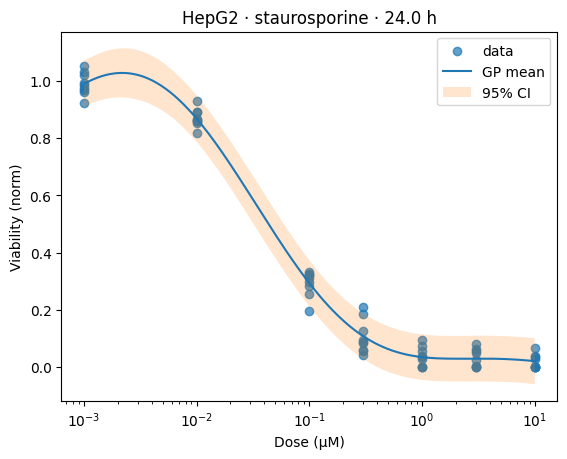

In [10]:
import matplotlib.pyplot as plt

# Choose one slice to visualize
cell_line = "HepG2"
compound = "staurosporine"
time_h = 24.0

gp = posterior.get_gp(cell_line, compound, time_h)
assert gp is not None, "No GP for this slice"

# Get raw data
df_slice = world.get_experiments_for_campaign("PHASE0_SANDBOX")
df_slice = df_slice[
    (df_slice["cell_line"] == cell_line)
    & (df_slice["compound"] == compound)
    & (df_slice["time_h"] == time_h)
]

# Predict on a smooth grid
lo = df_slice.query("dose_uM > 0")["dose_uM"].min()
hi = df_slice["dose_uM"].max()

grid = gp.predict_on_grid(
    num_points=200,
    dose_min=float(lo),
    dose_max=float(hi),
)
dose_grid = grid["dose_uM"]
mean = grid["mean"]
std = grid["std"]

plt.figure()
plt.scatter(df_slice["dose_uM"], df_slice["readout_value"], label="data", alpha=0.7)
plt.plot(dose_grid, mean, label="GP mean")
plt.fill_between(
    dose_grid,
    mean - 2 * std,
    mean + 2 * std,
    alpha=0.2,
    label="95% CI",
)
plt.xscale("log")
plt.xlabel("Dose (µM)")
plt.ylabel("Viability (norm)")
plt.title(f"{cell_line} · {compound} · {time_h} h")
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

def fit_gp_for_combo(data, cell_line, compound, time_h=24):
    # 1. Filter data to one cell line, one compound, one time, non-controls
    sub = data[
        (data["cell_line"] == cell_line) &
        (data["compound"] == compound) &
        (data["time_h"] == time_h) &
        (~data["is_control"].astype(bool))
    ].copy()

    # 2. Input X = dose, output y = normalized viability
    X = sub["dose_uM"].values.reshape(-1, 1)
    y = sub["viability_norm"].values

    # 3. Log-transform doses for geometry
    X_log = np.log10(np.clip(X, a_min=1e-6, a_max=None))

    # 4. Define the kernel: prior over what curves look like
    kernel = (
        ConstantKernel(1.0, (0.1, 10.0))  # overall vertical scale
        * RBF(length_scale=1.0, length_scale_bounds=(0.1, 5.0))  # smooth variation with dose
        + WhiteKernel(noise_level=0.05, noise_level_bounds=(1e-4, 0.5))  # measurement noise
    )

    # 5. Create and fit the GP
    gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=0.0,           # no extra diagonal noise, we already have WhiteKernel
        normalize_y=True,    # center and scale y internally
        n_restarts_optimizer=5  # refit the kernel hyperparameters from different starting points
    )

    gp.fit(X_log, y)

    # Return trained model plus the subset table
    return gp, sub


In [ ]:
def plot_dose_curve(gp, sub, title=""):
    # 1. Build a grid of doses to predict on
    positive = sub["dose_uM"][sub["dose_uM"] > 0]
    min_dose = positive.min() / 3
    max_dose = positive.max() * 3

    dose_grid = np.logspace(
        np.log10(min_dose),
        np.log10(max_dose),
        200
    ).reshape(-1, 1)

    X_grid_log = np.log10(dose_grid)

    # 2. Ask the GP for mean and std at each dose
    mean, std = gp.predict(X_grid_log, return_std=True)

    # 3. Plot
    plt.figure()
    # Raw data points
    plt.scatter(sub["dose_uM"], sub["viability_norm"], label="data")
    # GP mean curve
    plt.plot(dose_grid, mean, label="GP mean")
    # Uncertainty band
    plt.fill_between(
        dose_grid.ravel(),
        mean - 2 * std,
        mean + 2 * std,
        alpha=0.2,
        label="95% CI"
    )
    plt.xscale("log")
    plt.xlabel("Dose (µM)")
    plt.ylabel("Viability (norm)")
    plt.title(title)
    plt.legend()
    plt.show()
